In [1]:
## Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
filename = "monthdata.csv"
filepath = os.path.join("..","data",filename)

In [3]:
months = pd.read_csv(filepath,index_col=False, header=0)

In [4]:
series = pd.Series.from_csv(filepath, header=0)
#series = pd.read_csv(filepath, header=0)



/anaconda3/envs/PythonData_3/lib/python3.6/site-packages/pandas/core/series.py:3727: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


YYYYMM
1989-01-01    2.792
1989-02-01    3.010
1989-03-01    4.147
1989-04-01    4.571
1989-05-01    5.046
Name: Value, dtype: float64


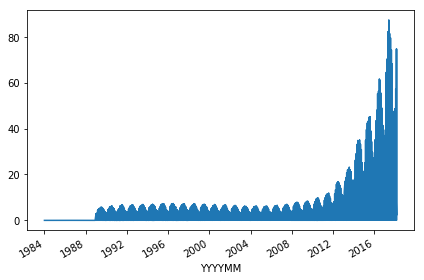

In [5]:
print(series.head())
series.plot()
# Save our graph 
plt.tight_layout()
plt.savefig("../images/timeserie.png")
plt.show()

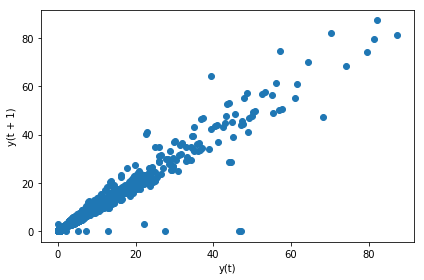

In [6]:
#from pandas.tools.plotting import lag_plot
from pandas.plotting import lag_plot
lag_plot(series)
# Save our graph 
plt.tight_layout()
plt.savefig("../images/lag_plot.png")
plt.show()

In [7]:
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.973276
t+1  0.973276  1.000000


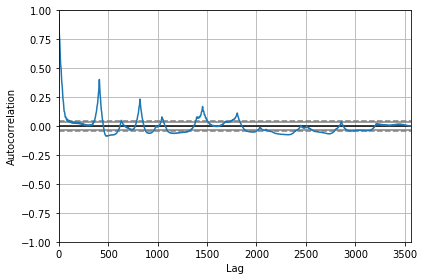

In [8]:
#from pandas.tools.plotting import autocorrelation_plot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
# Save our graph 
plt.tight_layout()
plt.savefig("../images/autocorr.png")
plt.show()

/anaconda3/envs/PythonData_3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


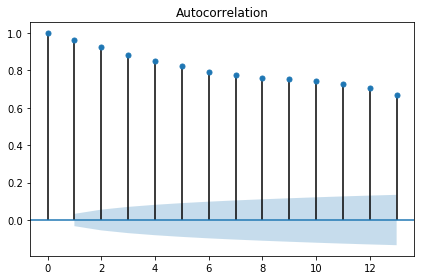

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series, lags=13)
# Save our graph 
plt.tight_layout()
plt.savefig("../images/acf.png")
plt.show()

Test MSE: 186.529


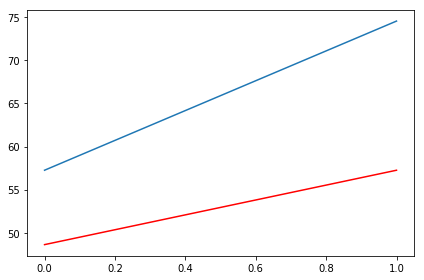

In [10]:
from sklearn.metrics import mean_squared_error
# create lagged dataset
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-2], X[len(X)-2:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
	return x

# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
plt.plot(test_y)
plt.plot(predictions, color='red')
# Save our graph 
plt.tight_layout()
plt.savefig("../images/model_persistence.png")
plt.show()

Lag: 29
Coefficients: [ 0.06347402  1.03163145 -0.04390437 -0.04388647 -0.07359071  0.19189181
 -0.20234247  0.02604268  0.02536461  0.18929545 -0.07949947  0.02375065
  0.13441455 -0.27350284  0.04955727  0.06068841 -0.0116743  -0.07420357
  0.04449958 -0.00206113 -0.04849878 -0.06237935  0.19013019 -0.02520154
  0.05171472 -0.02729557 -0.06006486 -0.03308382  0.01349146  0.01609994]
predicted=68.611028, expected=70.208000
predicted=72.221916, expected=82.084000
predicted=72.250525, expected=87.309000
predicted=69.936263, expected=81.295000
predicted=68.110891, expected=79.435000
predicted=60.232663, expected=74.195000
predicted=52.427029, expected=68.260000
predicted=45.748496, expected=47.416000
predicted=45.747208, expected=45.697000
predicted=47.568979, expected=48.632000
predicted=51.967275, expected=57.253000
predicted=59.824573, expected=74.537000
Test MSE: 106.480


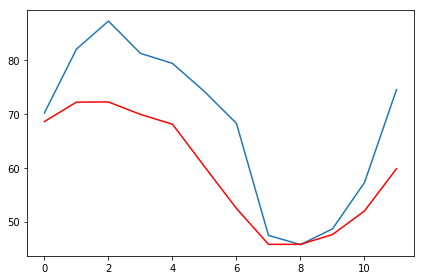

In [11]:
from statsmodels.tsa.ar_model import AR
# split dataset
X = series.values
train, test = X[1:len(X)-12], X[len(X)-12:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
# Save our graph 
plt.tight_layout()
plt.savefig("../images/ARmodel.png")
plt.show()

predicted=68.611028, expected=70.208000
predicted=73.869403, expected=82.084000
predicted=82.354447, expected=87.309000
predicted=84.967985, expected=81.295000
predicted=78.617453, expected=79.435000
predicted=70.336097, expected=74.195000
predicted=66.296496, expected=68.260000
predicted=61.072076, expected=47.416000
predicted=44.756235, expected=45.697000
predicted=46.540880, expected=48.632000
predicted=54.633348, expected=57.253000
predicted=68.010776, expected=74.537000
Test MSE: 30.724


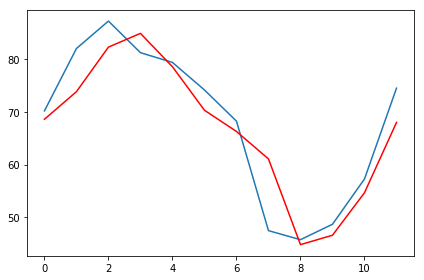

In [12]:
# split dataset
X = series.values
train, test = X[1:len(X)-12], X[len(X)-12:]
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
# Save our graph 
plt.tight_layout()
plt.savefig("../images/ARmodel_history.png")
plt.show()